In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import numpy as np
import sys

from importlib import reload

import hdbscan

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

sys.path.insert(1, '..')

import repsys

In [64]:
class MovieLens(repsys.Dataset):
    def name(self):
        return "movielens"

In [71]:
dataset = MovieLens()
dataset.load_dataset()

In [79]:
class KNN(repsys.Model):
  def __init__(self, k=5):
    self.model = NearestNeighbors(n_neighbors=k, metric="cosine")
    self.svd = TruncatedSVD(n_components=20, random_state=42)

  def name(self):
    return "KNN5"

  def fit(self):
    self.train_embed = self.svd.fit_transform(self.dataset.train_data)
    self.model.fit(self.train_embed)

  def predict(self, X, **kwargs):
    vad_embed = self.svd.transform(X)

    print("Embeddings computed")

    distances, indexes = self.model.kneighbors(vad_embed)

    print("Distances computed")

    n_distances = distances[:, 1:]
    n_indexes = indexes[:, 1:]

    n_distances = 1 - n_distances

    sums = n_distances.sum(axis=1)
    n_distances = n_distances / sums[:, np.newaxis]

    print("Distances normalized")

    predictions = np.array(
        [
            self.dataset.train_data[idx]
            .multiply(dist.reshape(-1, 1))
            .sum(axis=0)
            for idx, dist in zip(n_indexes, n_distances)
        ]
    ).squeeze(axis=1)

    print("Predictions completed")

    predictions[X.toarray() > 0] = 0

    print("History erased")

    return predictions

In [80]:
model = KNN()
model.update_data(dataset)
model.fit()

In [81]:
evaluator = repsys.Evaluator(model)
evaluator.evaluate_model(dataset.test_data_tr, dataset.test_data_te)
evaluator.print_results()

Embeddings computed
Distances computed
Distances normalized
Predictions completed
History erased
Recall@5=0.19891 (0.00228)
Recall@20=0.25587 (0.00238)
Recall@50=0.34093 (0.00262)
NCDG@100=0.27133 (0.00193)


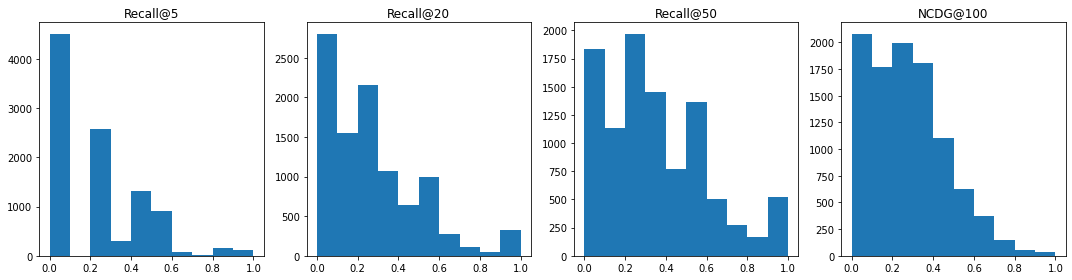

In [82]:
evaluator.plot_distributions()

## Embeddings Space

In [83]:
tsne = TSNE(random_state=42)
X_embedded = tsne.fit_transform(model.train_embed)

/Users/jean/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/jean/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [18]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=12)
clusterer.fit(X_embedded)

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], c=clusterer.labels_)
plt.show()